In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

In [3]:
data = pd.read_excel('data.xlsx')
data["DATE"] = pd.to_datetime(data["DATE"])
data.set_index('DATE', inplace=True)
indexes = list(data.columns)

In [4]:
data_base100 = data.copy()
for col in indexes:
    data_base100[col] = (data_base100[col] / data_base100[col].iloc[0]) * 100
fig = px.line(data_base100, x=data.index, y=indexes,
              title="Évolution des indices en base 100",
              labels={"value": "Prix des indices", "variable": "Indices", "Date": "Date"})

# Afficher le graphique
fig.show()

### Calcul des fenetres glissantes

In [5]:
data_returns = data.copy()
for col in indexes:
    data_returns[col] = (data_returns[col] / data_returns[col].shift(1))-1

In [6]:
returns_5yr = pd.DataFrame(index=data_returns.index)
vol_5yr = pd.DataFrame(index=data_returns.index)
cvar_5yr = pd.DataFrame(index=data_returns.index)
window_size = 60 # Fenetre de 5 ans donc 60 observations
confidence_level = 0.95 # Interval de confiance de la CVaR
for col in indexes:
    returns_5yr[col] = (
        (data_returns[col] + 1)
        .rolling(window=window_size)
        .apply(np.prod, raw=True) ** (12 / window_size) - 1
    ) * 100  # En pourcentage
    # Volatilité annualisée sur 5 ans (fenêtre glissante)
    vol_5yr[col] = data_returns[col].rolling(window=window_size
                    ).std() * np.sqrt(12) * 100
returns_5yr.dropna(inplace=True)
vol_5yr.dropna(inplace=True)

In [7]:
fig = px.line(returns_5yr.dropna(), x=returns_5yr.dropna().index, y=indexes,
              title="Rendements annualisé sur 5 ans des indices boursiers",
              labels={"value": "Rendements (%)", "variable": "Indices", "Date": "Date"})

# Afficher le graphique
fig.show()

In [8]:
fig = px.line(vol_5yr.dropna(), x=vol_5yr.dropna().index, y=indexes,
              title="Volatilité annualisé sur 5 ans des indices boursiers",
              labels={"value": "Volatilité (%)", "variable": "Indices", "Date": "Date"})
fig.show()

### Calcul des rendements et Vol moyennes

In [37]:
cov_matrix = np.cov(data_returns.dropna(), rowvar=False)*12*100  # Matrice de covariance
mean_returns = np.mean(returns_5yr, axis=0)
mean_vol = np.mean(vol_5yr, axis=0)
np.fill_diagonal(cov_matrix, mean_vol**2)

In [38]:
cov_matrix

array([[2.88304148e+02, 1.73571677e+00, 2.59673381e+00, 2.58833800e+00,
        6.40751907e-02, 7.53896017e-02],
       [1.73571677e+00, 1.78340480e+02, 1.74666944e+00, 1.76322211e+00,
        4.29720492e-02, 3.04519213e-02],
       [2.59673381e+00, 1.74666944e+00, 3.38183997e+02, 2.55214221e+00,
        6.17768574e-02, 4.37868721e-02],
       [2.58833800e+00, 1.76322211e+00, 2.55214221e+00, 3.96567399e+02,
        7.82384677e-02, 1.05433577e-01],
       [6.40751907e-02, 4.29720492e-02, 6.17768574e-02, 7.82384677e-02,
        5.31909890e+00, 1.28904588e-01],
       [7.53896017e-02, 3.04519213e-02, 4.37868721e-02, 1.05433577e-01,
        1.28904588e-01, 2.62479608e+01]])

## Markovitz RDT VOL 

In [39]:
def portfolio_stats(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

In [40]:
results = {"returns": [], "volatility": [], "sharpe": [], "weights": []}
num_assets = len(indexes)
num_points = 100000
for _ in tqdm(range(num_points)):
    weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()  # Poids aléatoires
    p_return, p_volatility, p_sharpe = portfolio_stats(weights, mean_returns, cov_matrix)
    results["returns"].append(p_return)
    results["volatility"].append(p_volatility)
    results["sharpe"].append(p_sharpe)
    results["weights"].append(weights)

100%|██████████| 100000/100000 [00:06<00:00, 15873.19it/s]


In [41]:
# Conversion en tableaux NumPy pour faciliter les calculs
returns  = np.array(results["returns"])
volatilities  = np.array(results["volatility"])
sharpe = np.array(results["sharpe"])
weights = np.array(results["weights"])

In [42]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
bounds = Bounds(0, 1)
linear_constraint = LinearConstraint(np.ones((len(indexes),), dtype=int),1,1)
min_vol = lambda w: np.sqrt(np.dot(w,np.dot(w,cov_matrix)))
weights = np.ones(len(indexes))
x0 = weights/np.sum(weights)
weights_min_vol = minimize(min_vol,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds).x
return_min_vol, vol_min_vol, sharpe_min_vol = portfolio_stats(weights_min_vol, mean_returns, cov_matrix)

In [43]:
weights_min_vol, return_min_vol, vol_min_vol, sharpe_min_vol

(array([0.0140121 , 0.02297513, 0.01195004, 0.01012168, 0.78495656,
        0.1559845 ]),
 3.037826742720269,
 2.0490967253930745,
 1.4825199343078976)

In [44]:
max_sharpe = lambda w: np.sqrt(np.dot(w,np.dot(w,cov_matrix)))/mean_returns.dot(w)
weights_max_sharpe = minimize(max_sharpe,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds).x
return_max_sharpe, vol_max_sharpe, sharpe_max_sharpe = portfolio_stats(weights_max_sharpe, mean_returns, cov_matrix)

In [45]:
weights_max_sharpe,return_max_sharpe, vol_max_sharpe, sharpe_max_sharpe

(array([0.02732631, 0.0436265 , 0.02594696, 0.01119594, 0.6891422 ,
        0.20276208]),
 3.256221962865074,
 2.1214781075807734,
 1.5348836036674003)

In [46]:
num_ports = 100  # Nombre de portefeuilles à calculer sur la frontière
gap = (np.amax(mean_returns) - np.dot(mean_returns,weights_min_vol)) / num_ports  # Écart de rendement entre les points
all_weights = np.zeros((num_ports, len(indexes)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
all_weights[0, :] = weights_min_vol
ret_arr[0] = np.dot(mean_returns,weights_min_vol)
vol_arr[0] = np.sqrt(np.dot(weights_min_vol,np.dot(weights_min_vol,cov_matrix)))
all_weights[1, :] = weights_max_sharpe
ret_arr[1] = np.dot(mean_returns,weights_max_sharpe)
vol_arr[1] = np.sqrt(np.dot(weights_max_sharpe,np.dot(weights_max_sharpe,cov_matrix)))
# Calcul des portefeuilles sur la frontière
for i in tqdm(range(2, num_ports)):  # Commence à 2 car les deux premiers points sont déjà définis
    port_ret = np.dot(mean_returns,weights_max_sharpe) + i * gap  # Rendement cible pour ce portefeuille
    
    # Contraintes : Somme des poids = 1, et rendement atteint la cible
    double_constraint = LinearConstraint([np.ones(len(indexes)),mean_returns],[1,port_ret],[1,port_ret])

    # Définir la fonction de volatilité du portefeuille
    fun = lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    # Point de départ pour l'optimisation
    x0 = weights_min_vol

    # Résolution du problème avec minimisation de la volatilité
    result = minimize(fun, x0, method='trust-constr', constraints=double_constraint, bounds=bounds)

    # Stocker les résultats
    all_weights[i, :] = result.x
    ret_arr[i] = port_ret
    vol_arr[i] = np.sqrt(np.dot(result.x,np.dot(result.x,cov_matrix)))

sharpe_arr = ret_arr/vol_arr  

 94%|█████████▍| 92/98 [00:04<00:00, 21.52it/s]c:\Users\bapdu\anaconda3\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning:

Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.

c:\Users\bapdu\anaconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

c:\Users\bapdu\anaconda3\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:81: UserWarning:

Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.

c:\Users\bapdu\anaconda3\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning:

Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.

c:\Users\bapdu\anaconda3\L

In [47]:
import plotly.graph_objects as go
def weights_plot(ptf_weights):
        fig = go.Figure()
        '''Attribut "stackgroup" permet d'empiler les plots'''
        for column in ptf_weights.columns:
            fig.add_trace(go.Scatter(x=vol_arr, y=ptf_weights[column],
                                        mode='lines', stackgroup='one', name=column))

        fig.update_layout(title=f"Evolution of optimal portfolio weights for the different returns", xaxis_title="Volatility (%)",
            yaxis_title="Weight (%)", yaxis=dict(tickformat=".0%", range=[0, 1]),
            legend_title="Assets", hovermode="x unified")
        
        return fig

In [48]:
df_weights= pd.DataFrame(all_weights, columns=indexes)
weights_plot(df_weights)

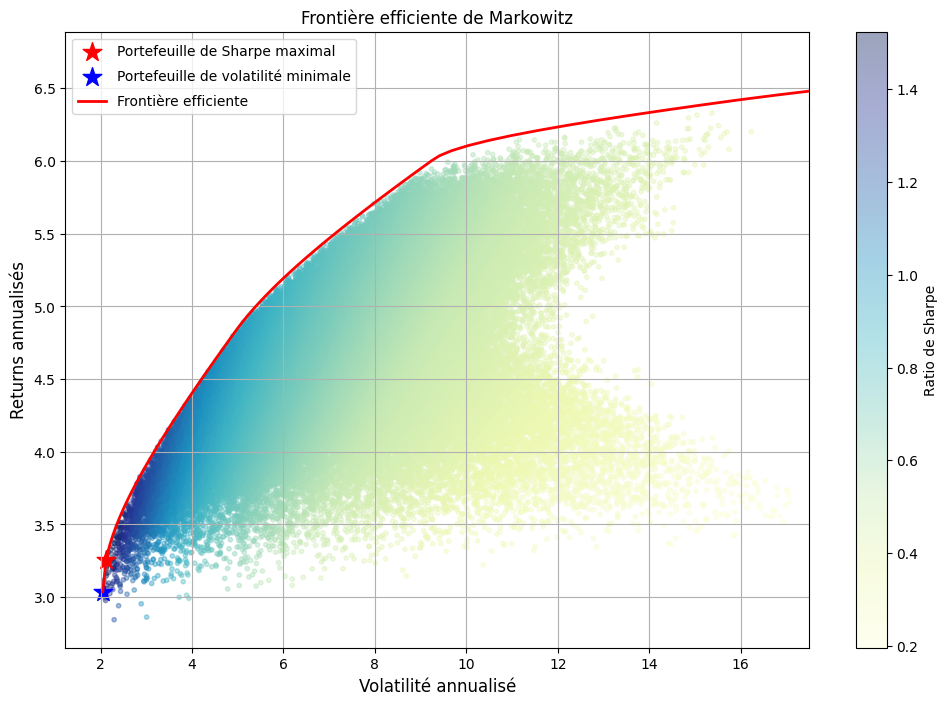

In [54]:
plt.figure(figsize=(12, 8))
# Nuage de points pour les portefeuilles simulés
plt.scatter(results["volatility"], results["returns"], c=results["sharpe"], cmap='YlGnBu', marker='o', s=10, alpha=0.4)
plt.colorbar(label='Ratio de Sharpe')
plt.scatter(
    vol_max_sharpe, return_max_sharpe, 
    color="red", label="Portefeuille de Sharpe maximal", marker="*", s=200
)
plt.scatter(
    vol_min_vol, return_min_vol, 
    color="blue", label="Portefeuille de volatilité minimale", marker="*", s=200
)
plt.plot(
    vol_arr, ret_arr, 
    color="red", label="Frontière efficiente", linewidth=2
)
plt.title("Frontière efficiente de Markowitz")
plt.xlabel('Volatilité annualisé', fontsize=12)
plt.ylabel('Returns annualisés', fontsize=12)
plt.legend(labelspacing=0.8)
plt.grid(True)
plt.xlim(right=17.5)
plt.show()

## CVAR

In [9]:
def ratio_cvar(mean_return, cvar, min_cvar):
    return mean_return/(cvar+min_cvar+0.000001)

In [10]:
def compute_cvar(window, confidence_level = 0.95):
    var = np.percentile(window, (1 - confidence_level) * 100)  # Calcul de la VaR
    cvar = np.mean(window[window <= var])  # Calcul empirique de la CVaR
    return cvar  

In [12]:
# Nombre de portefeuilles à simuler
num_portfolios = 10000

# Initialisation des résultats
results = np.zeros((2, num_portfolios))
weighs_dict = np.zeros((num_portfolios, len(indexes)))
# Simulation des portefeuilles
for i in tqdm(range(num_portfolios)):
    # Générer des poids aléatoires pour chaque actif
    weights = np.random.random(len(indexes))
    weights /= np.sum(weights)  # Normalisation des poids pour qu'ils somme à 1
    
    # Calcul du rendement attendu du portefeuille
    #portfolio_returns = np.dot(returns_5yr, weights)
    portfolio_returns = np.dot(returns_5yr, weights)
    mean_return = np.mean(np.dot(returns_5yr, weights))
    cvar = compute_cvar(portfolio_returns)
    # Stocker les résultats
    results[0, i] = mean_return
    results[1, i] = cvar
    #results[2, i] = ratio_cvar(mean_return, cvar)
    weighs_dict[i, :] = np.array(weights)
    #results[3, i] = weights
# Identifier le portefeuille avec le meilleur ratio de Sharpe
# max_ratio_idx = np.argmax(results[2])
# max_sharpe_return = results[0, max_sharpe_idx]
# max_sharpe_volatility = results[1, max_sharpe_idx]

# # Identifier le portefeuille avec la volatilité minimale
# min_volatility_idx = np.argmin(results[1])
# min_volatility_return = results[0, min_volatility_idx]
# min_volatility_volatility = results[1, min_volatility_idx]

# Tracer la frontière efficiente

# # Marquer les portefeuilles optimaux
# plt.scatter(max_sharpe_volatility, max_sharpe_return, color='r', marker='*', s=200, label="Portefeuille Max Sharpe")
# plt.scatter(min_volatility_volatility, min_volatility_return, color='g', marker='*', s=200, label="Portefeuille Min Volatility")

# plt.legend(loc='upper left')
# plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1122.04it/s]


In [13]:
min_var_idx = np.nanargmin(-results[1, :])  # Min VaR
min_weight, min_return, min_var= weighs_dict[min_var_idx], results[0, min_var_idx], -results[1, min_var_idx]

In [14]:
min_weight, min_return, min_var

(array([0.13508659, 0.41809676, 0.00611164, 0.00155115, 0.18618075,
        0.2529731 ]),
 4.725548294193447,
 -1.209779313413797)

In [80]:
ratios = np.array([ratio_cvar(mr, cv, min_var) for mr, cv in zip(results[0,:], -results[1, :])])

In [1]:
max_cvar_idx = np.nanargmax(ratios)  # Min VaR
weight_cvar, return_cvar, cvar_max= weighs_dict[max_cvar_idx], results[0, max_cvar_idx], -results[1, max_cvar_idx]

NameError: name 'np' is not defined

In [89]:
weight_cvar, return_cvar, cvar_max,ratios[max_cvar_idx]

(array([0.14254072, 0.04355291, 0.07536123, 0.3011639 , 0.18785838,
        0.24952286]),
 4.087851834983149,
 1.2093669164978202,
 68611.4319614336)

C:\Users\bapdu\AppData\Local\Temp\ipykernel_23472\3372480342.py:2: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



Text(0, 0.5, 'Rendement attendu')

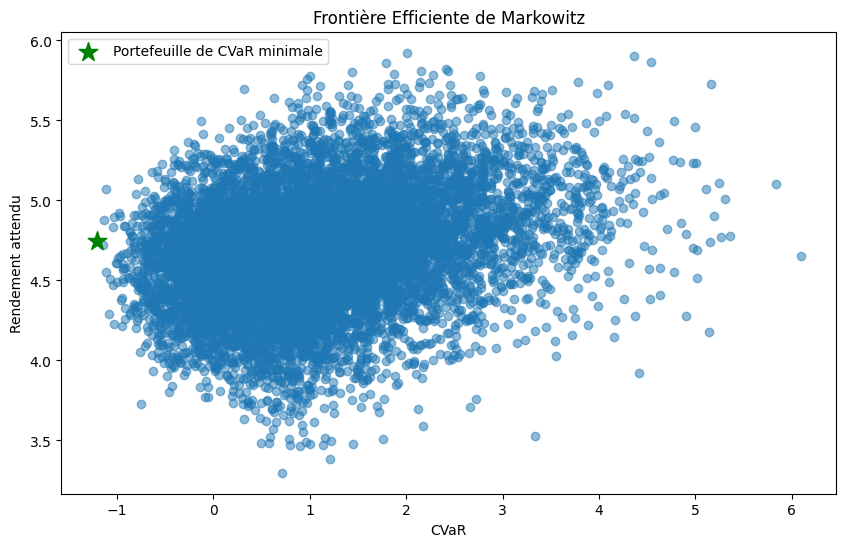

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(-results[1, :], results[0, :], cmap='YlGnBu', marker='o', alpha=0.5)
plt.scatter(
    min_var, min_return, 
    color="green", label="Portefeuille de CVaR minimale", marker="*", s=200
)

plt.title('Frontière Efficiente de Markowitz')
plt.legend(labelspacing=0.8)
plt.xlabel('CVaR')
plt.ylabel('Rendement attendu')

## Other

In [120]:
num_portfolios = 10000
import plotly.graph_objects as go
# Initialisation des résultats
results = np.zeros((3, num_portfolios))

# Simulation des portefeuilles
for i in range(num_portfolios):
    # Générer des poids aléatoires pour chaque actif
    weights = np.random.random(len(indexes))
    weights /= np.sum(weights)  # Normalisation des poids pour qu'ils somme à 1
    
    # Calcul du rendement attendu du portefeuille
    portfolio_return = np.sum(weights * mean_returns)
    
    # Calcul de la volatilité (écart-type) du portefeuille à partir de la matrice de covariance
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Stocker les résultats
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = (portfolio_return - 0.01) / portfolio_volatility  # Ratio de Sharpe (taux sans risque de 1%)

# Identifier le portefeuille avec le meilleur ratio de Sharpe
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]

# Identifier le portefeuille avec la volatilité minimale
min_volatility_idx = np.argmin(results[1])
min_volatility_return = results[0, min_volatility_idx]
min_volatility_volatility = results[1, min_volatility_idx]

# Créer la figure avec Plotly
fig = go.Figure()

# Ajouter les portefeuilles simulés
fig.add_trace(go.Scatter(
    x=results[1, :],
    y=results[0, :],
    mode='markers',
    marker=dict(color=results[2, :], colorscale='YlGnBu', size=5, opacity=0.5),
    name='Portefeuilles simulés',
    hovertemplate='Rendement: %{y:.2f}<br>Volatilité: %{x:.2f}<br>Ratio de Sharpe: %{marker.color:.2f}<extra></extra>'
))

# Ajouter le portefeuille avec le meilleur ratio de Sharpe
fig.add_trace(go.Scatter(
    x=[max_sharpe_volatility],
    y=[max_sharpe_return],
    mode='markers',
    marker=dict(color='red', size=10, symbol='star'),
    name='Portefeuille Max Sharpe',
    hovertemplate=f'Portefeuille Max Sharpe<br>Rendement: {max_sharpe_return:.2f}<br>Volatilité: {max_sharpe_volatility:.2f}<extra></extra>'
))

# Ajouter le portefeuille avec la volatilité minimale
fig.add_trace(go.Scatter(
    x=[min_volatility_volatility],
    y=[min_volatility_return],
    mode='markers',
    marker=dict(color='green', size=10, symbol='star'),
    name='Portefeuille Min Volatility',
    hovertemplate=f'Portefeuille Min Volatility<br>Rendement: {min_volatility_return:.2f}<br>Volatilité: {min_volatility_volatility:.2f}<extra></extra>'
))

# Ajouter les informations sur le graphique
fig.update_layout(
    title='Frontière Efficiente de Markowitz',
    xaxis_title='Volatilité',
    yaxis_title='Rendement attendu',
    coloraxis_colorbar=dict(
        title="Ratio de Sharpe",
        tickvals=[-1, 0, 1],
        ticktext=["-1", "0", "1"]
    ),
    template='plotly_dark',
    hovermode="closest"
)

# Afficher le graphique
fig.show()